# TOV Emulator to train a NN to predict Mass, Radius and Tidal Deformability of a Neutron Strar from a PP EOS - Final

### <div style= 'color: goldenrod'> Import all the required modules

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import torch
import itertools
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange
from numba import jit

import tov_tide
%matplotlib widget

### <div style= 'color: goldenrod'> Global constants and unit conversion factors

In [2]:
msun=147660                 # Solar mass in cm given by the formula G*M_sun/c^2

c=2.9979e10                 # speed of light in cm/s (CGS)
G=6.67408e-8                # gravitational constant in cm^3/gm/s^2 (CGS)

dkm = 1.3234e-06            # conversion of MeV/fm^3 to km^-2
dcgs = 1.78e12              # factor to convert from MeV/fm^3 to gm/cm^3
conv = 8.2601e-40           # dyn/cm^2 to km^-2
cgs1=1.7827e+12             # MeV/fm3 to gms/cm3
cgs2=1.6022e+33             # MeV/fm3 to dyne/cm2

### <div style= 'color: goldenrod'>4 Piecewise-polytrope low-density (crust) parameters

In [3]:
# Low density Polytropic exponents
GammaL_1 = 1.35692
GammaL_2 = 0.62223
GammaL_3 = 1.28733
GammaL_4 = 1.58425

# Low density Polytropic constants
KL_1 = 3.99874e-8 # * pow(Msun/Length**3, GammaL_1-1)
KL_2 = 5.32697e+1 # * pow(Msun/Length**3, GammaL_2-1)
KL_3 = 1.06186e-6 # * pow(Msun/Length**3, GammaL_3-1)
KL_4 = 6.80110e-9 # * pow(Msun/Length**3, GammaL_4-1)
# notice a missing c^2 in Ki values in Table II of Read et al. 2009

# Densities at the boundaries of the low density piecewise polytropes
rhoL_1 = 2.62789e12
rhoL_2 = 3.78358e11
rhoL_3 = 2.44034e7
rhoL_4 = 0.0

# Pressures at the boundaries of the low density piecewise polytropes
pL_1 = KL_1*rhoL_1**GammaL_1
pL_2 = KL_2*rhoL_2**GammaL_2
pL_3 = KL_3*rhoL_3**GammaL_3
pL_4 = 0.0

# The exact numbers are taken from a particular crust model/table.

### <div style= 'color: goldenrod'> Low density Energy density, α, and Break densities

In [4]:
# Compute the offsets specific internal energy (epsL_i) and alphaL_i at the 
# boundaries
# The general form used: ε(ρ)=(1+α)ρ+K/(Γ−1)ρ^Γ. 
# Solving for alpha ensures matching across boundaries.
# Energy density needs an additive offset to enforce continuity.

epsL_4 = 0.0
alphaL_4 = 0.0
epsL_3 = (1+alphaL_4)*rhoL_3 + KL_4/(GammaL_4 - 1.)*pow(rhoL_3, GammaL_4)
alphaL_3 = epsL_3/rhoL_3 - 1.0 - KL_3/(GammaL_3 - 1.)*pow(rhoL_3, GammaL_3 -1.0)
epsL_2 = (1+alphaL_3)*rhoL_2 + KL_3/(GammaL_3 - 1.)*pow(rhoL_2, GammaL_3)
alphaL_2 = epsL_2/rhoL_2 - 1.0 - KL_2/(GammaL_2 - 1.)*pow(rhoL_2, GammaL_2 -1.0)
epsL_1 = (1+alphaL_2)*rhoL_1 + KL_2/(GammaL_2 - 1.)*pow(rhoL_1, GammaL_2)
alphaL_1 = epsL_1/rhoL_1 - 1.0 - KL_1/(GammaL_1 - 1.)*pow(rhoL_1, GammaL_1 -1.0)

# Density thresholds for high-density polytropes
rho1 = pow(10,14.7) # Break Density 1
rho2 = pow(10,15.0) # Break Density 2

# GR conversion prefactors to go from cgs pressure/energy-density units into 
# geometric units (where G=c=1)
t_p=G/c**4
t_rho=G/c**2

### <div style= 'color: goldenrod'> Forward EOS: ρ↦(p,ε)
To calculate pressure and energy density for polytropes based on the central density region of intrest

In [5]:
def p_eps_of_rho(rho,logp,Gamma1,Gamma2,Gamma3):
    p1 = pow(10.0,logp)/c**2
    K1 = p1/pow(rho1,Gamma1)
    K2 = K1 * pow( rho1, Gamma1-Gamma2)
    K3 = K2 * pow( rho2, Gamma2-Gamma3)
    rho0 = pow(KL_1/K1,1.0/(Gamma1-GammaL_1)) 
    eps0 = (1.0+alphaL_1)*rho0 + KL_1/(GammaL_1-1.0)*pow(rho0,GammaL_1)
    alpha1 = eps0/rho0 - 1.0 - K1/(Gamma1 - 1.0)*pow(rho0, Gamma1 -1.0)
    eps1 = (1.0+alpha1)*rho1 + K1/(Gamma1 - 1.0)*pow(rho1, Gamma1)
    alpha2 = eps1/rho1 - 1.0 - K2/(Gamma2 - 1.0)*pow(rho1, Gamma2 -1.0)
    eps2 = (1.0+alpha2)*rho2 + K2/(Gamma2 - 1.0)*pow(rho2, Gamma2)
    alpha3 = eps2/rho2 - 1.0 - K3/(Gamma3 - 1.0)*pow(rho2, Gamma3 -1.0)
    if rho<rhoL_3:
        p = KL_4*pow(rho,GammaL_4)
        eps = (1.0+alphaL_4)*rho + KL_4/(GammaL_4-1.0)*pow(rho,GammaL_4)
    elif rhoL_3<= rho <rhoL_2:
        p = KL_3*pow(rho,GammaL_3)
        eps = (1.0+alphaL_3)*rho + KL_3/(GammaL_3-1.0)*pow(rho,GammaL_3)
    elif rhoL_2<= rho <rhoL_1:
        p = KL_2*pow(rho,GammaL_2)
        eps = (1.0+alphaL_2)*rho + KL_2/(GammaL_2-1.0)*pow(rho,GammaL_2)
    elif rhoL_1<= rho <rho0:
        p = KL_1*pow(rho,GammaL_1)
        eps = (1.0+alphaL_1)*rho + KL_1/(GammaL_1-1.0)*pow(rho,GammaL_1)
    elif rho0<= rho <rho1:
        p = K1*pow(rho,Gamma1)
        eps = (1.0+alpha1)*rho + K1/(Gamma1-1.0)*pow(rho,Gamma1)
    elif rho1<= rho <rho2:
        p = K2*pow(rho,Gamma2)
        eps = (1.0+alpha2)*rho + K2/(Gamma2-1.0)*pow(rho,Gamma2)
    else:
        p = K3*pow(rho,Gamma3)
        eps = (1.0+alpha3)*rho + K3/(Gamma3-1.0)*pow(rho,Gamma3)
    return p*c**2, eps*c**2

### <div style= 'color: goldenrod'> Inverse EOS: p↦ε
To calculate Energy denisty for every central pressure value of intrest 
while solving a polytrope

In [6]:
@jit(nopython=True)
def eps(p,logp,Gamma1,Gamma2,Gamma3):
    p1 = pow(10.0,logp)/c**2
    p*=1/c**2
    K1 = p1/pow(rho1,Gamma1)
    K2 = K1 * pow( rho1, Gamma1-Gamma2)
    K3 = K2 * pow( rho2, Gamma2-Gamma3)
    rho0 = pow(KL_1/K1,1.0/(Gamma1-GammaL_1))
    eps0 = (1.0+alphaL_1)*rho0 + KL_1/(GammaL_1-1.0)*pow(rho0,GammaL_1)
    alpha1 = eps0/rho0 - 1.0 - K1/(Gamma1 - 1.0)*pow(rho0, Gamma1 -1.0)
    eps1 = (1.0+alpha1)*rho1 + K1/(Gamma1 - 1.0)*pow(rho1, Gamma1)
    alpha2 = eps1/rho1 - 1.0 - K2/(Gamma2 - 1.0)*pow(rho1, Gamma2 -1.0)
    eps2 = (1.0+alpha2)*rho2 + K2/(Gamma2 - 1.0)*pow(rho2, Gamma2)
    alpha3 = eps2/rho2 - 1.0 - K3/(Gamma3 - 1.0)*pow(rho2, Gamma3 -1.0)
    p0 = K1*pow(rho0,Gamma1)
    p2 = K3*pow(rho2,Gamma3)
    if  p<pL_3:
        rho = pow(p/KL_4,1/GammaL_4)
        eps = (1.0+alphaL_4)*rho + KL_4/(GammaL_4-1.0)*pow(rho,GammaL_4)
    elif pL_3<= p <pL_2:
        rho = pow(p/KL_3,1/GammaL_3)
        eps = (1.0+alphaL_3)*rho + KL_3/(GammaL_3-1.0)*pow(rho,GammaL_3)
    elif pL_2<= p <pL_1:
        rho = pow(p/KL_2,1/GammaL_2)
        eps = (1.0+alphaL_2)*rho + KL_2/(GammaL_2-1.0)*pow(rho,GammaL_2)
    elif  pL_1<p <p0:
        rho = pow(p/KL_1,1/GammaL_1)
        eps = (1.0+alphaL_1)*rho + KL_1/(GammaL_1-1.0)*pow(rho,GammaL_1)
    elif p0<= p <p1:
        rho = pow(p/K1,1/Gamma1)
        eps = (1.0+alpha1)*rho + K1/(Gamma1-1.0)*pow(rho,Gamma1)
    elif p1<= p <p2:
        rho = pow(p/K2,1/Gamma2)
        eps = (1.0+alpha2)*rho + K2/(Gamma2-1.0)*pow(rho,Gamma2)
    else:
        rho = pow(p/K3,1/Gamma3)
        eps = (1.0+alpha3)*rho + K3/(Gamma3-1.0)*pow(rho,Gamma3)
    return eps*c**2

### <div style= 'color: goldenrod'> The TOV Integrator

In [7]:
def TOV(logrho_c, theta, compute_tidal=True):
    logp, Gamma1, Gamma2, Gamma3 = theta
    dr = 100.0              # radial step in meters

    rho_c = 10**logrho_c    # Central density in cgs units (g/cm^3)
    r = 0.1                 # Initial Radius (Non-zero to avoid singularity)
    m = 0.0                 # Initial Mass

    p, e = p_eps_of_rho(rho_c, logp, Gamma1, Gamma2, Gamma3)
    p *= t_p    # pressure in geometric units
    e *= t_p    # energy density in geometric units

    # Store profiles to calculate TD
    p_prof = []
    e_prof = []
    r_prof = []
    m_prof = []

    while p > 0:    # As long as pressure is greater than 0
        p_prof.append(p)
        e_prof.append(e)
        r_prof.append(r)
        m_prof.append(m)

        dp = -(e + p) * (m + 4*np.pi*r**3*p) / (r*(r - 2*m))
        p += dp * dr    # Update pressure at each radial step
        if p <= 0:      # Break when pressure reaches 0
            break

        m += 4*np.pi*r**2 * e * dr  # Update mass
        r += dr                     # Update radius
        e = eps(p/t_p, logp, Gamma1, Gamma2, Gamma3) * t_p # Update energy density

    # --- Final mass and radius ---
    M = m / msun
    R = r / 1e5

    if not compute_tidal:
        return M, R

    # prepare inputs for Fortran tov_tide.tov_tide
    p_prof = np.array(p_prof, dtype=np.float64)
    e_prof = np.array(e_prof, dtype=np.float64)
    # Fortran expects central pressure at index N
    p_prof = p_prof[::-1]
    e_prof = e_prof[::-1]
    pc = p_prof[-1]
    # N = len(p_prof)

    # --- Calculate tidal deformability ---
    M_tide, R_tide, L = tov_tide.tov_tide(
        e_prof,
        p_prof,
        pc
    )
    return M, R, L # Returns true TD (not log TD)

### <div style= 'color: Yellow'> Produce a Mass-Radius curve and Tidal deformability vs Compactness plot for a single EOS

In [ ]:
logrho_c_array=np.linspace(14.5,15.4,100) # log central density values
theta=[34.495, 3.446, 3.572, 2.887] # [logp, Gamma1, Gamma2, Gamma3]

seq=[]
td_seq = []
for logrho_c in logrho_c_array:
    m, r, td=TOV(logrho_c,theta, compute_tidal=True)
    seq.append((m,r))
    td_seq.append(td)
    
seq=np.array(seq)
td_seq = np.array(td_seq)

compactness = seq[:, 0] * 1.4766 / seq[:, 1] # Compactness in geometric units

# M-R PLot
plt.figure()
plt.plot(seq[:,1],seq[:,0])
plt.grid()
plt.xlabel('Radius (km)')
plt.ylabel(r'$M \, (M_{\odot})$')
plt.show()

# Log TD plot
plt.figure()
plt.plot(compactness, td_seq)
plt.yscale("log")
plt.grid()
plt.xlabel(r"$Compactness (M/R) $")
plt.ylabel("Log Tidal Deformability")
plt.show()


### <div style= 'color: slateblue'>Create dataset of EOS parameter samples & run TOV to create targets

In [8]:
NUM_SAMPLES = 40000 # Number of EOS samples
# Directory to save/load dataset and models 
# If not defined, model will save in current directory.
save_dir = f"Copied over from Cluster/{NUM_SAMPLES}files"

In [ ]:
# ==========================================================
# Define ranges for input parameters
# ==========================================================
EOS_params = np.random.uniform( low=[1.4, 1.4, 1.4], 
                                high=[5., 5., 5.], 
                                size=(NUM_SAMPLES, 3)
                                )
logp_samples = np.random.uniform(33.5, 34.8, size=(NUM_SAMPLES, 1))

logrho_c_samples = np.random.uniform(14.5, 15.4, size=(NUM_SAMPLES, 1))

MRL_data = []

for i in trange(NUM_SAMPLES, desc="Solving TOV"):
    logrho_c = logrho_c_samples[i, 0]
    logp = logp_samples[i, 0]
    params = EOS_params[i]

    M, R, L = TOV(
        logrho_c,
        [logp, params[0], params[1], params[2]],
        compute_tidal = True
        )
    MRL_data.append([M, R, L])

MRL_data = np.array(MRL_data)

# ==========================================================
# Apply mask to filter out unphysical outputs produced by extremely stiff EOSs
# ==========================================================
M = MRL_data[:, 0]
R = MRL_data[:, 1]
L = MRL_data[:, 2]
mask = (
    np.isfinite(M) &
    np.isfinite(R) &
    (M > 0.15) & (M < 3.5) &
    (R > 6.0) & (R < 25.0) &
    (L > 0) & (L < 1e6)
)

# Stack the cleaned dataset
EOS_data = np.hstack([
    logrho_c_samples[mask],
    logp_samples[mask],
    EOS_params[mask],
    MRL_data[mask]
])
print(f"Kept {EOS_data.shape[0]} / {NUM_SAMPLES} samples")

# Save the cleaned dataset
os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, f"EOS_dataset_{NUM_SAMPLES}files.npy"), EOS_data)
print("Datasets created and saved!")

### <div style= 'color: goldenrod'> PyTorch ML pipeline — load data for sanity check

In [9]:
# Load created dataset
data = np.load(os.path.join(save_dir, f"EOS_dataset_{NUM_SAMPLES}files.npy"))

# Checking the dataset with added column headers
Column_headers = ['log_rho_c', 'log_p', 'Gamma1', 'Gamma2', 'Gamma3',
                  'Mass_Msun', 'Radius_km', 'TD']
df = pd.DataFrame(data, columns=Column_headers)

# df.head()       # Show first 5 values in each column
df.describe() # Max and min values for each column

# Radius should be within 6 and 24km
# Tidal deformability must be logged

,log_rho_c,log_p,Gamma1,Gamma2,Gamma3,Mass_Msun,Radius_km,TD
count,31339.000000,31339.000000,31339.000000,31339.000000,31339.000000,31339.000000,31339.000000,31339.000000
mean,15.026667,34.228354,3.186849,3.245221,3.207909,1.358543,11.160561,53268.032446
std,0.232364,0.357602,1.032050,1.034266,1.032965,0.794204,2.456804,151804.113101
min,14.500047,33.500084,1.400315,1.400022,1.400016,0.153194,6.224001,0.368775
25%,14.850310,33.947007,2.289482,2.363128,2.324358,0.624886,9.512001,10.522000
50%,15.043693,34.258502,3.179369,3.265942,3.204061,1.281491,10.777001,349.236251
75%,15.223920,34.534213,4.074701,4.144801,4.096407,2.042391,12.279001,12675.948910
max,15.399966,34.799984,4.999710,4.999951,4.999878,3.265677,24.990001,999544.347136


### <div style= 'color: goldenrod'> PyTorch ML pipeline — prepare data

In [10]:
# Set device and batch size fo training 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
BATCH_SIZE = 256

################################################################################
# 1. Split into training and validation sets (80 / 20)
################################################################################
split_idx = int(0.8 * len(data))
train_data = data[:split_idx]
val_data = data[split_idx:]

################################################################################
# 2. Convert to Tensor
################################################################################
# Inputs: Cols 0 to 4 (5 features: log_rho_c, log_p, Gamma1, Gamma2, Gamma3)
# Output: Col 5 - 7 (Mass, Radius, Tidal Deformability)
X_eos_train = torch.tensor(train_data[:, :5], dtype=torch.float32)  # Training Input
y_eos_train = torch.tensor(train_data[:, 5:8], dtype=torch.float32) # Training Output

X_eos_val = torch.tensor(val_data[:, :5], dtype=torch.float32)      # Validation Input
y_eos_val = torch.tensor(val_data[:, 5:8], dtype=torch.float32)     # Validation Output

################################################################################
# 3. Normalize the all the inputs using Z-score (Pressure is already logged)
################################################################################
X_eos_mean = X_eos_train.mean(dim=0, keepdim=True)
X_eos_std = X_eos_train.std(dim=0, keepdim=True)
# Save the normalization statistics to be used later for maodel evaluation
torch.save(X_eos_mean, os.path.join(save_dir, "X_eos_mean.pt"))
torch.save(X_eos_std, os.path.join(save_dir, "X_eos_std.pt"))
print("Normalization statistics saved.")
X_train_norm = (X_eos_train - X_eos_mean) / X_eos_std
X_val_norm = (X_eos_val - X_eos_mean) / X_eos_std

################################################################################
# 4. Separate the outputs (Mass, Radius and TD) from the training and validation datasets
################################################################################
y_mass_train, y_radius_train, y_td_train = y_eos_train[:, 0:1], y_eos_train[:, 1:2], y_eos_train[:, 2:3]
y_mass_val, y_radius_val, y_td_val = y_eos_val[:, 0:1], y_eos_val[:, 1:2], y_eos_val[:, 2:3]

################################################################################
# 5. Normalize the outputs
################################################################################
# 5.1  Constant Scaling on Mass (M)
MASS_SCALE = 3.5
y_mass_train_norm = y_mass_train / MASS_SCALE
y_mass_val_norm = y_mass_val / MASS_SCALE

# 5.2. Constant Scaling on Radius (R)
RADIUS_SCALE = 25.0
y_radius_train_norm = y_radius_train / RADIUS_SCALE
y_radius_val_norm = y_radius_val / RADIUS_SCALE

# 5.3 Log Scaling on Tidal Deformability (TD)
y_td_train_norm = torch.log10(y_td_train)
y_td_val_norm = torch.log10(y_td_val)

################################################################################
# 6. Recombine Outputs
################################################################################
y_train_norm = torch.cat((y_mass_train_norm, y_radius_train_norm, y_td_train_norm), dim=1)
y_val_norm = torch.cat((y_mass_val_norm, y_radius_val_norm, y_td_val_norm), dim=1)


Using device: cuda
Normalization statistics saved.


### <div style= 'color: orange'> Range of values of the parameters <b>before</b> scaling and normalizing

In [11]:
print("Log Central Density min/max:", np.round(train_data[:, 0].min(), 3), np.round(train_data[:, 0].max(), 3))
print("Log Central Pressure min/max:", np.round(train_data[:, 1].min(), 3), np.round(train_data[:, 1].max(), 3))
print("Gamma 1 min/max:", np.round(train_data[:, 2].min(), 3), np.round(train_data[:, 2].max(), 3))
print("Gamma 2 min/max:", np.round(train_data[:, 3].min(), 3), np.round(train_data[:, 3].max(), 3))
print("Gamma 3 min/max:", np.round(train_data[:, 4].min(), 3), np.round(train_data[:, 4].max(), 3))
print("")
print("Mass min/max:", np.round(train_data[:, 5].min(), 3), np.round(train_data[:, 5].max(), 3))
print("Radius min/max:", np.round(train_data[:, 6].min(), 3), np.round(train_data[:, 6].max(), 3))
print("Tidal Deformability min/max:", np.round(train_data[:, 7].min(), 3), np.round(train_data[:, 7].max(), 3))

train_data.shape

Log Central Density min/max: 14.5 15.4
Log Central Pressure min/max: 33.5 34.8
Gamma 1 min/max: 1.4 5.0
Gamma 2 min/max: 1.4 5.0
Gamma 3 min/max: 1.4 5.0

Mass min/max: 0.153 3.266
Radius min/max: 6.224 24.99
Tidal Deformability min/max: 0.369 999544.347


(25071, 8)

### <div style= 'color: orange'> Range of values of the parameters <b>after</b> scaling and normalizing

In [12]:
print("Log Central Density min/max:", np.round(X_train_norm[:, 0].min(), 3), np.round(X_train_norm[:, 0].max(), 3))
print("Log Central Pressure min/max:", np.round(X_train_norm[:, 1].min(), 3), np.round(X_train_norm[:, 1].max(), 3))
print("Gamma 1 min/max:", np.round(X_train_norm[:, 2].min(), 3), np.round(X_train_norm[:, 2].max(), 3))
print("Gamma 2 min/max:", np.round(X_train_norm[:, 3].min(), 3), np.round(X_train_norm[:, 3].max(), 3))
print("Gamma 3 min/max:", np.round(X_train_norm[:, 4].min(), 3), np.round(X_train_norm[:, 4].max(), 3))
print("")
print("Mass min/max:", np.round(y_train_norm[:, 0].min(), 3), np.round(y_train_norm[:, 0].max(), 3))
print("Radius min/max:", np.round(y_train_norm[:, 1].min(), 3), np.round(y_train_norm[:, 1].max(), 3))
print("Tidal Deformability min/max:", np.round(y_train_norm[:, 2].min(), 3), np.round(y_train_norm[:, 2].max(), 3))

train_data.shape

Log Central Density min/max: tensor(-2.2610) tensor(1.6090)
Log Central Pressure min/max: tensor(-2.0340) tensor(1.5970)
Gamma 1 min/max: tensor(-1.7290) tensor(1.7570)
Gamma 2 min/max: tensor(-1.7870) tensor(1.6980)
Gamma 3 min/max: tensor(-1.7530) tensor(1.7400)

Mass min/max: tensor(0.0440) tensor(0.9330)
Radius min/max: tensor(0.2490) tensor(1.)
Tidal Deformability min/max: tensor(-0.4330) tensor(6.)


(25071, 8)

### <div style= 'color: Yellow'> NN Definition

In [13]:
################################################################################
# Single Residual Network Block
################################################################################
class ResNetBlock(nn.Module):
    def __init__(self, hidden_dim, auxiliary_dim=1):
        super().__init__()
        # We accept the hidden state + the auxiliary Central Pressure injection
        self.fc = nn.Linear(hidden_dim + auxiliary_dim, hidden_dim)
        self.act = nn.GELU() # Gaussian Error Linear Unit
    
    def forward(self, x, cp):
        # Concatenate Central Pressure to the input of the layer
        combined = torch.cat([x, cp], dim=1)
        out = self.act(self.fc(combined))
        return x + out # Residual connection

################################################################################
# Set up the Residual Network flow
################################################################################
class PhysicsEmulator(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512): 
        super().__init__()
        # Separate EOS inputs from Central Pressure
        # input_dim is 5: (4 EOS params + 1 Central Pressure)
        self.eos_dim = input_dim - 1 
        
        # 1. Initial encoding of EOS parameters only: 
        self.input_layer = nn.Linear(self.eos_dim, hidden_dim)
        
        # 2. Deep Residual Layers with Central Pressure Injection
        self.block1 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block2 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block3 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block4 = ResNetBlock(hidden_dim, auxiliary_dim=1)

        # 3. Output layers
        self.final_layer = nn.Sequential(
            nn.Linear(hidden_dim + 1, hidden_dim // 2), # Inject Central Pressure one last time
            nn.GELU(),                                      # 513 --> 256
            nn.Linear(hidden_dim // 2, 3)                   # Output: 256 --> 3
        )
        
    def forward(self, x):
        # Split input into EOS params and Central Pressure
        # Central Pressure is the second column
        cp = x[:, 1:2]
        # EOS parameters are the remaining columns
        eos_params = torch.cat([x[:, 0:1], x[:, 2:]], dim=1)

        # 1. Encode EOS
        x_hidden = self.input_layer(eos_params)           # Input: 5 --> 512

        # 2. Central Pressure-Injected Residual Flow: Pass through blocks, injecting Central Pressure at each step
        x_hidden = self.block1(x_hidden, cp)              # 512 + 1 --> 512
        x_hidden = self.block2(x_hidden, cp)              # 512 + 1 --> 512
        x_hidden = self.block3(x_hidden, cp)              # 512 + 1 --> 512
        x_hidden = self.block4(x_hidden, cp)              # 512 + 1 --> 512
        
        # 3. Final Prediction
        # Concatenate Central Pressure one last time for the read-out
        combined_final = torch.cat([x_hidden, cp], dim=1) # 512 + 1 = 513
        return self.final_layer(combined_final)             

### <div style= 'color: goldenrod'> Train the model (batch-wise gradient descent) and plot losses

In [ ]:
################################################################################
# Plotting function
################################################################################
def plot_and_save_losses(train_losses, val_losses, filename="loss_curve.png"):
    """Plots training and validation loss and saves the figure."""

    epochs = range(len(train_losses))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Huber Loss (Normalized)')
    plt.yscale('log') # Using log scale for clearer visualization of small losses
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    try:
        plt.savefig(os.path.join(save_dir, filename))
        print(f"Loss plot saved to {filename}", flush=True)
    except Exception as e:
        print(f"ERROR saving plot: {e}", flush=True)
    plt.close()

################################################################################
# Set training paramters
################################################################################
model = PhysicsEmulator().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=1000, eta_min=1e-7
            )   # Modulates adaptive learning rate
criterion = nn.HuberLoss()
epochs = 1000   # With early stopping
patience = 100  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf')

# Lists to store losses for plotting
train_losses = []
val_losses = []

################################################################################
# Load training and validation tensors
################################################################################
# Ensure Mass and Radius are Torch Tensors
if isinstance(y_train_norm, np.ndarray):
    y_train_norm = torch.from_numpy(y_train_norm).to(torch.float32)
if isinstance(y_val_norm, np.ndarray):
    y_val_norm = torch.from_numpy(y_val_norm).to(torch.float32)

train_loader = DataLoader(TensorDataset(X_train_norm, y_train_norm), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_norm, y_val_norm), batch_size=BATCH_SIZE, shuffle=False)

################################################################################
# Training
################################################################################
for epoch in range(epochs):
    # 1. Set model in training mode
    model.train()
    train_loss = 0.0
    for X_b, y_b in train_loader:
        X_b, y_b = X_b.to(DEVICE), y_b.to(DEVICE)
        optimizer.zero_grad()       # Clear previous gradient
        pred = model(X_b)           # Make prediction
        loss = criterion(pred, y_b) # Calculate training loss
        loss.backward()             # Backpropagate loss
        optimizer.step()            # Use optimizer
        train_loss += loss.item()   # Update training loss
    
    train_loss /= len(train_loader)
    
    # 2. Set model in evaluation mode
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_b, y_b in val_loader:
            X_b, y_b = X_b.to(DEVICE), y_b.to(DEVICE)
            pred = model(X_b)           # Make prediction
            loss = criterion(pred, y_b) # Calculate validation loss
            val_loss += loss.item()     # Update validation loss
    
    val_loss /= len(val_loader)
    scheduler.step()                    # Update Scheduler
    
    # 3. Append Losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # 4. Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model weights
        best_model_state = model.state_dict()

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # 5. Calculate and print error in output parameters every 100 epochs
    if epoch % 100 == 0:
        # Calculate the Approximate Physical Error in km
        radius_error_km = np.sqrt(2 * val_loss) * RADIUS_SCALE 
        mass_error = np.sqrt(2 * val_loss) * MASS_SCALE
        td_error_log = np.sqrt(2 * val_loss)  # Since td is log-scaled, this is in log units

        print(f"Epoch {epoch} | Train Loss: {train_loss:.6e} | Val Loss: {val_loss:.6e} | Approx Radius Error: {radius_error_km:.4f} km | Approx Mass Error: {mass_error:.4f} | Approx TD error: {td_error_log:.4f}", flush=True)

        # 6. Plot and save errors
        # Plot every 100 epochs
        if epoch % 100 == 0 and epoch > 0:
            plot_and_save_losses(train_losses, val_losses, filename=f"loss_curve_epoch{epoch}.png")

# Restore best model
model.load_state_dict(best_model_state)
print(f"Training finished. Best validation loss: {best_val_loss:.10f}")

# 7. Final PLot after training finishes
plot_and_save_losses(train_losses, val_losses, filename="loss_curve_final.png")
torch.save(model.state_dict(), os.path.join(save_dir, "Best_EOS_Model.pth"))

### <div style= 'color: Yellow'> Evaluate Model for grid of CD + CP + EOS parameters

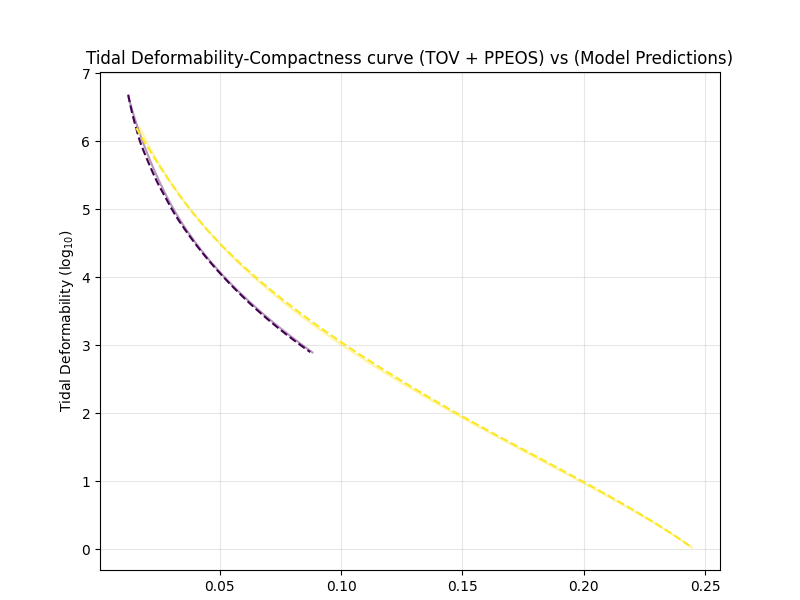

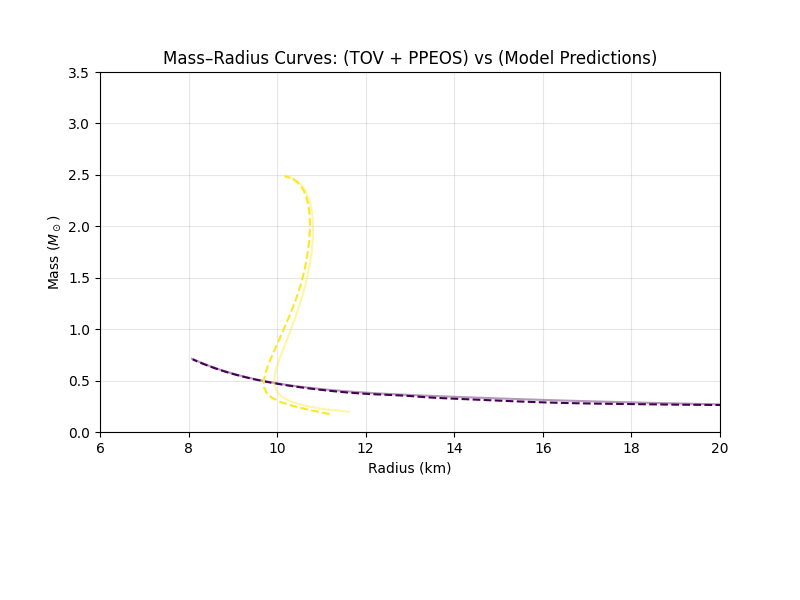

In [15]:
################################################################################
# 1. Configuration and constants
################################################################################
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RADIUS_SCALE = 25.0
MASS_SCALE = 3.5

MODEL_NO = 2

################################################################################
# 2. Set ranges for the parameters of the EOS for the curves to be tested
################################################################################
Gamma1_values = [1.6, 2.5, 3.5, 4.5, 4.9]   # Should be within training range.
Gamma2_values = [1.6, 2.5, 3.5, 4.5, 4.9]   # Values outside the training range
Gamma3_values = [1.6, 2.5, 3.5, 4.5, 4.9]   # would be extrapolation

logp_values = [33.6, 34.0, 34.4, 34.8]

logrho_c_array = np.linspace(14.5, 15.4, 60) # sample different central densities

# Randomly select combinations of (Γ1,Γ2,Γ3,logp)
param_combinations = list(itertools.product(Gamma1_values, Gamma2_values, Gamma3_values, logp_values))
sampled_combinations = random.sample(param_combinations, 2)  # 5 random combos

################################################################################
# 3. Prepare models and Scalars
################################################################################
# Call model to device
model = PhysicsEmulator().to(DEVICE)
model.load_state_dict(torch.load(os.path.join(save_dir, "Best_EOS_Model.pth"), map_location=DEVICE))
model.eval() # Set model in evaluation mode

# Load the means and stds for normalization from training
X_mean = torch.load(os.path.join(save_dir, "X_eos_mean.pt")).to(DEVICE)
X_std = torch.load(os.path.join(save_dir, "X_eos_std.pt")).to(DEVICE)

# Initialize lists to store results
predicted_mass = []
predicted_radius = []
predicted_td = []
original_mass = []
original_radius = []
original_td = []

################################################################################
# 4. Evaluation and plot loop
################################################################################
fig1, ax1 = plt.subplots(figsize=(8, 6))
fig2, ax2 = plt.subplots(figsize=(8, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(sampled_combinations)))

for color, (Gamma1, Gamma2, Gamma3, logp) in zip(colors, sampled_combinations):
    predicted_mass_single = []
    predicted_radius_single = []
    predicted_td_single = []

    original_mass_single = []
    original_radius_single = []
    original_td_single = []

    for logrho_c in logrho_c_array:
        # Normalize all input parameters using Z-Score
        input_eos_params = torch.tensor([[logrho_c, logp, Gamma1, Gamma2, Gamma3]], dtype=torch.float32).to(DEVICE)
        input_norm = ((input_eos_params - X_mean) / X_std).to(DEVICE)

        # Predict M, R and TD with trained model
        with torch.no_grad():
            prediction = model(input_norm)

        # Bring predictions to cpu
        pred = prediction.cpu().numpy()

        # Denormalize outputs
        M_pred_denorm = float(pred[0, 0] * MASS_SCALE)
        R_pred_denorm = float(pred[0, 1] * RADIUS_SCALE)
        TD_pred_log = float(pred[0, 2])  # Keep log scaling

        # Remove unphysical predictions
        if not (
            np.isfinite(M_pred_denorm) and
            np.isfinite(R_pred_denorm) and
            np.isfinite(TD_pred_log) and
            0.15 < M_pred_denorm < 3.5 and
            6.0 < R_pred_denorm < 25.0 and
            0 < TD_pred_log < 10.0

        ):
            continue

        # Calculate Original TOV solutions using the TOV solver
        M_orig, R_orig, TD_orig = TOV(logrho_c, [logp, Gamma1, Gamma2, Gamma3])

        # Remove unphysical values
        if not (
            np.isfinite(M_orig) and
            np.isfinite(R_orig) and
            np.isfinite(TD_orig) and
            0.15 < M_orig < 3.5 and
            6.0 < R_orig < 25.0 and
            0 < np.log10(TD_orig) < 10.0
        ):
            continue

        # Store single curve results
        predicted_mass_single.append(M_pred_denorm)
        predicted_radius_single.append(R_pred_denorm)
        original_mass_single.append(M_orig)
        original_radius_single.append(R_orig)
        predicted_td_single.append(TD_pred_log)
        original_td_single.append(np.log10(TD_orig))

    # Append to overall lists
    predicted_mass.append(predicted_mass_single)    
    predicted_radius.append(predicted_radius_single)
    original_mass.append(original_mass_single)
    original_radius.append(original_radius_single)
    original_td.append(original_td_single)
    predicted_td.append(predicted_td_single)

    # Convert lists to numpy arrays
    orig_M = np.array(original_mass_single)
    orig_R = np.array(original_radius_single)
    pred_M = np.array(predicted_mass_single)
    pred_R = np.array(predicted_radius_single)

    # Plot label
    label = rf"$\log\rho_c= {logrho_c:.2f}$, Γ=({Gamma1},{Gamma2},{Gamma3}), logp={logp:.2f}"

    # Plot M-R curves
    ax1.plot(original_radius_single, original_mass_single, '-', color=color, alpha=0.4, label=f"TOV {label}")
    ax1.plot(predicted_radius_single, predicted_mass_single, '--', color=color, label=f"Pred {label}")
    
    # Plot TD-Compactness Curves
    ax2.plot(orig_M / orig_R, original_td_single, "-", color=color, alpha=0.4, label=f"TOV + PPEOS {label}")
    ax2.plot(pred_M / pred_R, predicted_td_single, "--", color=color, label=f"Model Prediction {label}")

    # Plot Formatting
    ax1.set_title("Mass–Radius Curves: (TOV + PPEOS) vs (Model Predictions)")
    ax1.set_xlabel("Radius (km)")
    ax1.set_ylabel(r"Mass ($M_\odot$)")
    ax1.set_xlim(6, 20)
    ax1.set_ylim(0, 3.5)
    ax1.grid(alpha=0.3)

    ax2.set_title("Tidal Deformability-Compactness curve (TOV + PPEOS) vs (Model Predictions)")
    ax2.set_xlabel(r"Compactness ($M/R$)")
    ax2.set_ylabel("Tidal Deformability (log$_{10}$)")
    ax2.grid(alpha=0.3)

# M-R Plot Legend
fig1.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.18),
    fontsize="small",
    ncol=2
)
fig1.subplots_adjust(bottom=0.28)
# TD-Compactness Plot Legend
fig2.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    fontsize="small",
    ncol=2
)
fig2.subplots_adjust(bottom=0.05)

# Save both plots
# fig1.savefig(os.path.join(save_dir, f"MR_unseen{MODEL_NO}.svg"), bbox_inches="tight")
# fig2.savefig(os.path.join(save_dir, f"TD_compactness_unseen_{MODEL_NO}.svg"), bbox_inches="tight")

plt.show()

### <div style= 'color: yellow'> Model Metrics

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

orig_mass_all = np.concatenate(original_mass)
orig_radius_all = np.concatenate(original_radius)
orig_td_all = np.concatenate(original_td)

pred_mass_all = np.concatenate(predicted_mass)
pred_radius_all = np.concatenate(predicted_radius)
pred_td_all = np.concatenate(predicted_td)

# Mass Metrics
mae_mass = mean_absolute_error(orig_mass_all, pred_mass_all)
rmse_mass = np.sqrt(mean_squared_error(orig_mass_all, pred_mass_all))
r2_mass = r2_score(orig_mass_all, pred_mass_all)

# Radius Metrics
mae_radius = mean_absolute_error(orig_radius_all, pred_radius_all)
rmse_radius = np.sqrt(mean_squared_error(orig_radius_all, pred_radius_all))
r2_radius = r2_score(orig_radius_all, pred_radius_all)

# TD Metrics
mae_td = mean_absolute_error(orig_td_all, pred_td_all)
rmse_td = np.sqrt(mean_squared_error(orig_td_all, pred_td_all))
r2_td = r2_score(orig_td_all, pred_td_all)

# Normalized MSE of the model
norm_rmse = np.mean([
    rmse_radius / np.mean(orig_radius_all),
    rmse_mass / np.mean(orig_mass_all),
    rmse_td / np.mean(orig_td_all)
])

print(f"Radius:  MAE={mae_radius:.4f}, RMSE={rmse_radius:.4f}, R²={r2_radius:.4f}")
print(f"Mass:  RMSE={rmse_mass:.4f}, R²={r2_mass:.4f}")
print(f"TD:  MAE={mae_td:.4f}, RMSE={rmse_td:.4f}, R²={r2_td:.4f}")
print(f"Combined normalized RMSE = {norm_rmse:.4f}")

Radius:  MAE=0.0751, RMSE=0.1091, R²=0.9990
Mass:  RMSE=0.0114, R²=0.9997
TD:  MAE=0.0095, RMSE=0.0121, R²=1.0000
Combined normalized RMSE = 0.0090


In [ ]:
################################################################################
# Save Metrics to a Text file
################################################################################
output_file = os.path.join(save_dir, f"Model_metrics_{MODEL_NO}.txt")

with open(output_file, "w") as f:
    f.write("Mass, Radius and TD prediction metrics\n")
    f.write("======================================\n")

    f.write("Mass Prediction Metrics:\n")
    f.write(f"MAE   : {mae_mass:.6f}\n")
    f.write(f"RMSE  : {rmse_mass:.6f}\n")
    f.write(f"R^2   : {r2_mass:.6f}\n")
    f.write("\n")

    f.write("Radius Prediction Metrics:\n")
    f.write(f"MAE   : {mae_radius:.6f}\ n")
    f.write(f"RMSE  : {rmse_radius:.6f}\n")
    f.write(f"R^2   : {r2_radius:.6f}\n")
    f.write("\n")

    f.write("Tidal Deformability Prediction Metrics:\n")
    f.write(f"MAE   : {mae_td:.6f}\n")
    f.write(f"RMSE  : {rmse_td:.6f}\n")
    f.write(f"R^2   : {r2_td:.6f}\n")
    f.write("\n")

    f.write(f"Norm RMSE : {norm_rmse:.6f}\n")
    
print(f"Metrics saved to {output_file}")
